#**Thirty Categories**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setup

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


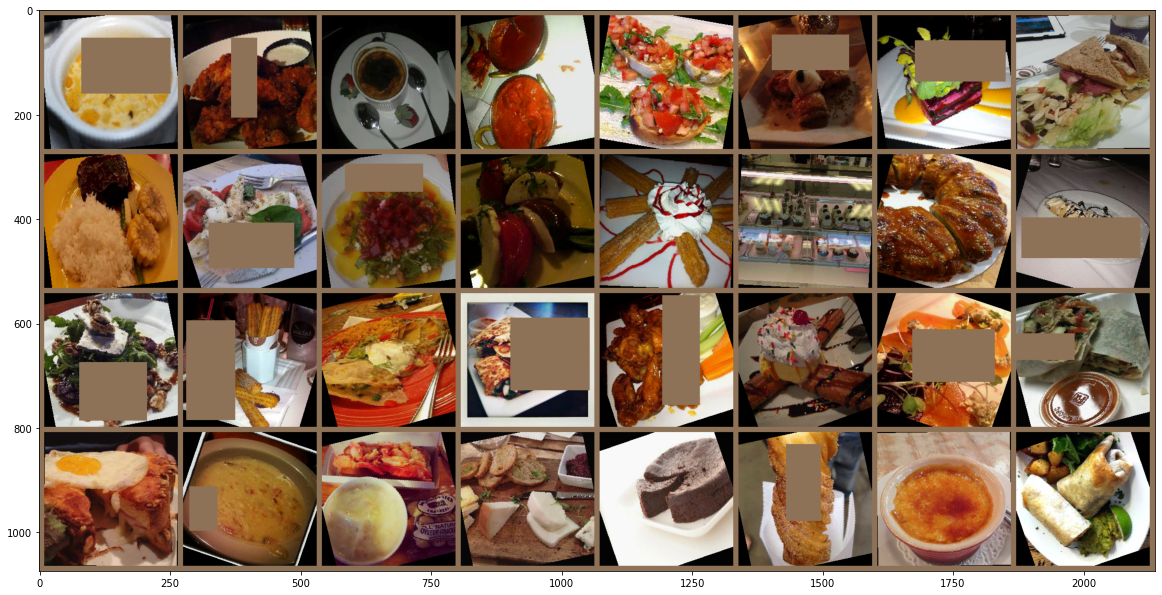

In [2]:
import os
import numpy as np
from tqdm import tqdm
import glob
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from  torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Other constants
num_classes = 30
model_save_name = '30_categories_checkpoint.pth'
path = F"/content/drive/My Drive/{model_save_name}" 
ROOT_PATH = '/content/drive/MyDrive/comp6721-project/datasets/dataset-30'
training_path = f'{ROOT_PATH}/train'
validation_path = f'{ROOT_PATH}/val'
evaluation_path = f'{ROOT_PATH}/test'

# Model training constants
batch_size = 32
num_epochs = 15

# Loss function & optimizer constants
lr = 0.001
momentum = 0.9
step_size = 5
gamma = 0.1

# Image constants
image_size = 256
mean = [0.554, 0.450, 0.343]
std = [0.231, 0.241, 0.241]

# Transform
main_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])

aug_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1,0.1,0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
    transforms.RandomErasing()
])

# Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=False)
in_features = int(model.fc.in_features)
model.fc = nn.Linear(in_features, num_classes, device)
model = model.to(device)

# Loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Dataset
train_dataset = datasets.ImageFolder(training_path, transform=aug_transform)
evaluation_dataset = datasets.ImageFolder(evaluation_path, transform=main_transform)

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=2)
evaluation_dataloader = DataLoader(evaluation_dataset, batch_size = batch_size, shuffle=False, num_workers=2)

# Image samples
images, targets = next(iter(train_dataloader))
grid_images = torchvision.utils.make_grid(images, nrow=8, padding=10)

def imshow(images, mean, std):
        np_image = np.array(images).transpose((1,2,0))
        unnorm_image = np_image * std + mean
        plt.figure(figsize=(20,20))
        plt.imshow(unnorm_image)
        
imshow(grid_images, mean, std)

## Training

In [3]:
# Training
%%time

losses = []
accuracy = []

for epoch in range(num_epochs):
    for i , (inputs, targets) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        #train model
        outputs = model(inputs)
        
        #criterion
        loss = criterion(outputs, targets)
        losses.append(loss.item())
        
        #backward
        optimizer.zero_grad()
        loss.backward()
        
        #update parameters
        optimizer.step()
        
        #accuracy
        _, predicted = torch.max(outputs.data, 1)
        total = targets.size(0)
        correct = (predicted == targets).sum().item()
        accuracy.append(correct / total)

        # report
        if (i + 1) % 50 == 0:
            print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f, Accuracy: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_dataset) // batch_size, loss.item(), correct / total))


Epoch [ 1/15], Step [ 50/751], Loss: 3.4013, Accuracy: 0.0312
Epoch [ 1/15], Step [100/751], Loss: 3.3574, Accuracy: 0.0625
Epoch [ 1/15], Step [150/751], Loss: 3.2732, Accuracy: 0.1562
Epoch [ 1/15], Step [200/751], Loss: 3.2615, Accuracy: 0.0312
Epoch [ 1/15], Step [250/751], Loss: 3.3179, Accuracy: 0.0625
Epoch [ 1/15], Step [300/751], Loss: 3.2462, Accuracy: 0.0625
Epoch [ 1/15], Step [350/751], Loss: 2.9431, Accuracy: 0.1875
Epoch [ 1/15], Step [400/751], Loss: 2.9208, Accuracy: 0.1562
Epoch [ 1/15], Step [450/751], Loss: 3.0702, Accuracy: 0.1250
Epoch [ 1/15], Step [500/751], Loss: 3.1050, Accuracy: 0.2188
Epoch [ 1/15], Step [550/751], Loss: 3.1672, Accuracy: 0.0625
Epoch [ 1/15], Step [600/751], Loss: 3.0999, Accuracy: 0.0625
Epoch [ 1/15], Step [650/751], Loss: 3.1139, Accuracy: 0.0312
Epoch [ 1/15], Step [700/751], Loss: 3.0369, Accuracy: 0.2188
Epoch [ 1/15], Step [750/751], Loss: 2.9731, Accuracy: 0.1875
Epoch [ 2/15], Step [ 50/751], Loss: 3.1357, Accuracy: 0.1875
Epoch [ 

## Save model

In [4]:
from google.colab import files


torch.save(model.state_dict(), path)


## Valuation

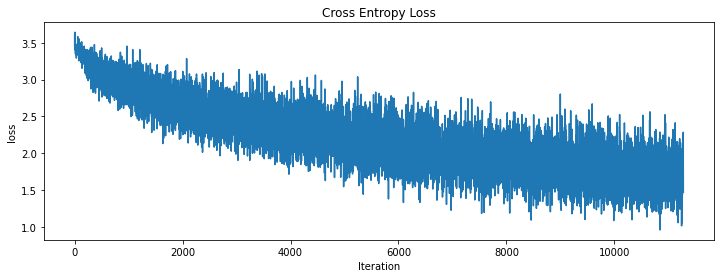

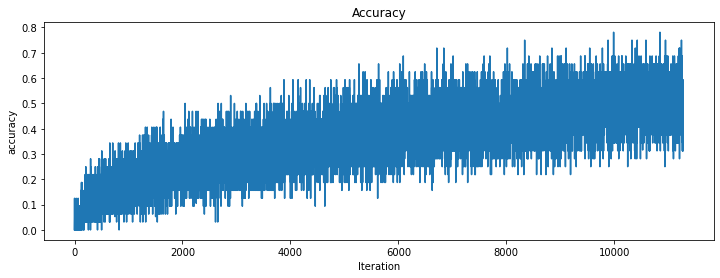

Train accuracy: 49.28
Test accuracy: 47.89
Confusion Matrix:
[[36  1 12  0  0  0  1  0  9  2  0  0  5  0  6  0  0  6  1  4  6  1  0  3
   4  1  0  0  0  0]
 [ 3 71  1  0  0  0  1  0  3  1  1  0  1  0  3  0  0  1  0  0 21  2  0  0
   0  1  4  0  0  0]
 [15  2 46  0  0  0  0  0  3  3  1  1  2  0  5  0  0  0  2  3  1  0  1  1
   3  1  2  1  1  1]
 [ 1  3  1 43  9  5  0  0  0  0 10  0  1 14  0  4  0  0  2  0  2  0  0  1
   0  0  1  0  1  1]
 [ 2  4  0  4 56  3  1  1  1  0 12  1  4  0  1  2  1  1  1  4  3  0  1  0
   0  1  8  4  0  0]
 [ 0  2  0  1  5 54  1  0  3  2  4  1  0  7  0  2  2  2  1  0  2  1  0  0
   0  2  3  1  0  0]
 [ 5  0  4  0  0  0 70  0  1  0  1  0  5  0  1  1  2  2  0  1  1  1  1  5
   1  0  0  0  0  0]
 [ 1 17  1  1  0  1  0 39  2  1  1  1  0  0  2  1  1  2  2  5  4  1  1  0
   0  0  4  0  1  2]
 [14  2  7  0  1  0  3  0 23  2  2  0  2  0  5  0  2  1  1  1  3  1  1  1
   1  0  4  3  0  1]
 [ 6  0  5  0  0  2  1  2  5 28  8  3  2  0  2  1  3  1  3  7  3  0  2  0
   0  3  6

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Cross Entropy Loss')
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(accuracy)
plt.xlabel('Iteration')
plt.ylabel('accuracy')
plt.title('Accuracy')
plt.show()


def evaluate_model(title, model, dataloader, device):
    model.eval()  # for batch normalization layers
    corrects = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += (preds == targets.data).sum()
            y_true.extend(targets.tolist())
            y_pred.extend(preds.tolist())

    print('{title} accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset), title=title))
    if title.lower() == "test":
        # Compute the confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        # Compute the precision, recall, and F1 score
        report = classification_report(y_true, y_pred)
        print('Confusion Matrix:')
        print(cm)
        print('Classification Report:')
        print(report)


evaluate_model("Train", model, train_dataloader, device)
evaluate_model("Test", model, evaluation_dataloader, device)

## t-SNE

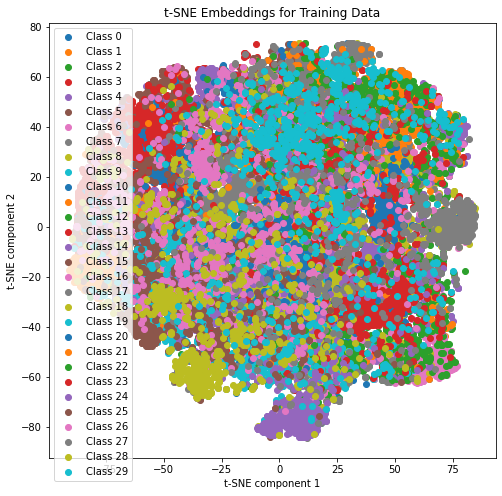

CPU times: user 5min 13s, sys: 6.71 s, total: 5min 19s
Wall time: 7min 23s


In [6]:
%%time
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

def compute_tsne(model, dataloader):
    """
    Computes t-SNE embeddings for the given model and dataloader.
    """
    # Set model to evaluation mode
    model.eval()
        
    # Get the features from the last layer for all samples in the dataset
    features = []
    labels = []

    # Define a function to extract the features from the last layer
    # def get_features_hook(module, input, output):
    #     features.append(output.detach().cpu().numpy())

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            # model.fc.register_forward_hook(get_features_hook)
            outputs = model(inputs)
            features.append(outputs.detach().cpu().numpy())
            labels.append(targets.detach().cpu().numpy())
    
    features = np.concatenate(features)
    labels = np.concatenate(labels)

    # Compute t-SNE embeddings
    tsne = TSNE(n_components=2, perplexity=30, random_state=0)
    embeddings = tsne.fit_transform(features)

    return embeddings, labels


train_embeddings, train_labels = compute_tsne(model, train_dataloader)
# Plot t-SNE embeddings for the training datasets
import matplotlib.pyplot as plt

# Plot t-SNE embeddings
plt.figure(figsize=(8,8))
for i in range(num_classes):
    plt.scatter(train_embeddings[train_labels==i,0], train_embeddings[train_labels==i,1], label=f'Class {i}')
plt.legend()
plt.title('t-SNE Embeddings for Training Data')
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.show()

# Helper: Save/Load model

In [ ]:
# Load model
from google.colab import files

state_dict = torch.load(path)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
# Valuation loaded model
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(title, model, dataloader, device):
    model.eval()  # for batch normalization layers
    corrects = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += (preds == targets.data).sum()
            y_true.extend(targets.tolist())
            y_pred.extend(preds.tolist())

    print('{title} accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset), title=title))
    if title.lower() == "test":
        # Compute the confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        # Compute the precision, recall, and F1 score
        report = classification_report(y_true, y_pred)
        print('Confusion Matrix:')
        print(cm)
        print('Classification Report:')
        print(report)


evaluate_model("Train", model, train_dataloader, device)
evaluate_model("Test", model, evaluation_dataloader, device)

Train accuracy: 78.16
Test accuracy: 76.01


NameError: ignored